In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [84]:
data_df = pd.read_csv('data.csv', index_col = 'Date', parse_dates = ['Date'])

In [85]:
#df.index = pd.to_datetime(data_df.index)

data_df['year'] = data_df.index.year
data_df['quarter'] = data_df.index.quarter
data_df['month'] = data_df.index.month
data_df['day'] = data_df.index.day
data_df['weekday'] = (data_df.index.weekday)
data_df['isweekend'] = (data_df.weekday > 4).astype(int)

# m = df.index.month
# data_df['year'] = df.index
# data_df['quarter'] = data_df.apply(lambda x: x.quarter)
# data_df['month'] = data_df.apply(lambda x: x.month)
# data_df['day'] = data_df.apply(lambda x: x.day)

In [86]:
data_df

,Count,year,quarter,month,day,weekday,isweekend
Date,,,,,,,
2019-01-01,93,2019,1,1,1,1,0
2019-01-02,204,2019,1,1,2,2,0
2019-01-03,200,2019,1,1,3,3,0
2019-01-04,116,2019,1,1,4,4,0
2019-01-05,19,2019,1,1,5,5,1
...,...,...,...,...,...,...,...
2019-12-27,126,2019,4,12,27,4,0
2019-12-28,13,2019,4,12,28,5,1
2019-12-29,68,2019,4,12,29,6,1


In [87]:
data_df.describe()

,Count,year,quarter,month,day,weekday,isweekend
count,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000
mean,179.3534,2019.0000,2.5096,6.5260,15.7205,2.9945,0.2849
std,108.6973,0.0000,1.1183,3.4526,8.8083,2.0027,0.4520
min,7.0000,2019.0000,1.0000,1.0000,1.0000,0.0000,0.0000
25%,77.0000,2019.0000,2.0000,4.0000,8.0000,1.0000,0.0000
50%,202.0000,2019.0000,3.0000,7.0000,16.0000,3.0000,0.0000
75%,255.0000,2019.0000,4.0000,10.0000,23.0000,5.0000,1.0000
max,580.0000,2019.0000,4.0000,12.0000,31.0000,6.0000,1.0000


### To extract maximum information from our data, it is important to have a normal or Gaussian distribution of the data. To check for that, we have done a normality test based on the Null and Alternate Hypothesis intuition.

In [88]:
stat, p = stats.normaltest(data_df.Count)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

Statistics=3.305, p=0.192
Data looks Gaussian (fail to reject H0)


Kurtosis of normal distribution: 0.05476584094059156
Skewness of normal distribution: 0.22571563441367903


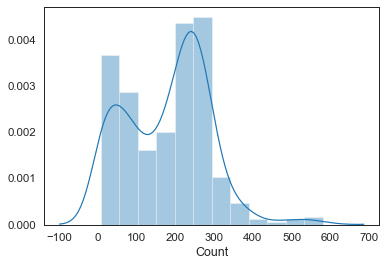

In [89]:
#  A value close to 0 for Kurtosis indicates a Normal Distribution where asymmetrical nature is signified by 
# a value between -0.5 and +0.5 for skewness. The tails are heavier for kurtosis greater than 0 and vice versa. 
# Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

sns.distplot(data_df.Count);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (data_df.Count)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (data_df.Count)))

### Box plot of yearly vs. quarterly Count

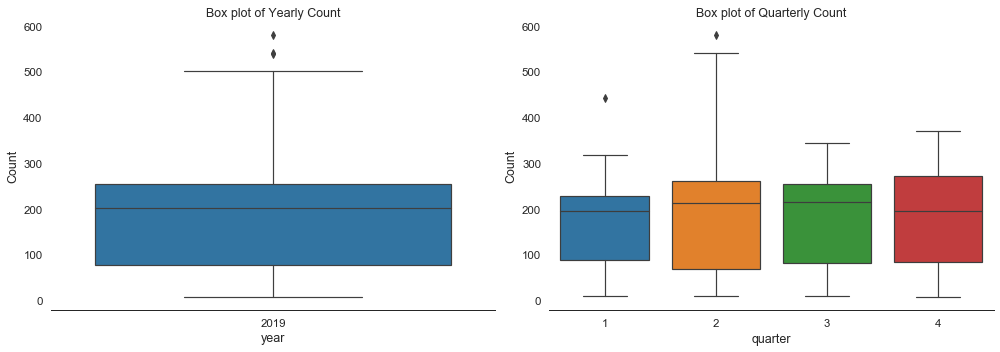

In [90]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Count", data=data_df)
plt.xlabel('year')
plt.title('Box plot of Yearly Count')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Count", data=data_df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Count')
sns.despine(left=True)
plt.tight_layout();

### Count in weekdays vs the weekends.

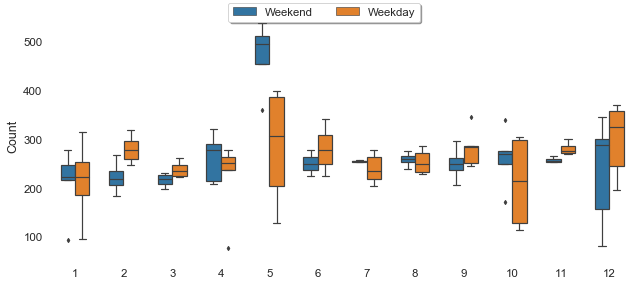

In [91]:
dic={1:'Weekend',0:'Weekday'}
data_df['Day'] = data_df.weekday.map(dic)

a=plt.figure(figsize=(9,4))
plt1=sns.boxplot('month', 'Count', hue='Day', 
                  width=0.6, fliersize=3, data=data_df )
a.legend(loc='upper center', bbox_to_anchor=(0.5,1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend().set_visible(False);

In [92]:
# For months 4 and 5 (April and May), there are significantly more tickets generated on weekends than on the weekdays

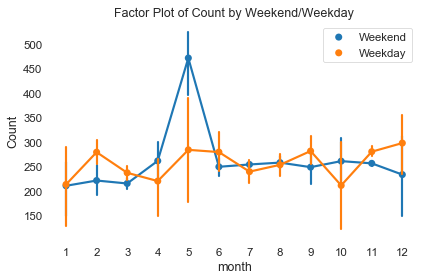

In [93]:
plt1=sns.factorplot('month','Count', hue='Day',
                    data=data_df, size=4, aspect=1.5, legend=False)
plt.title('Factor Plot of Count by Weekend/Weekday')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.legend(loc='upper right');

### Data Preprocessing

In [94]:
data_df.drop(columns=["Day"], axis=1, inplace=True)

In [95]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [96]:
# load dataset
values = data_df.values
# ensure all data is float
values = values.astype('float32')

In [97]:
# frame as supervised learning
reframed = series_to_supervised(values, 7, 1)

In [98]:
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
7,93.0000,2019.0000,1.0000,1.0000,1.0000,1.0000,0.0000,204.0000,2019.0000,1.0000,...,7.0000,0.0000,0.0000,246.0000,2019.0000,1.0000,1.0000,8.0000,1.0000,0.0000
8,204.0000,2019.0000,1.0000,1.0000,2.0000,2.0000,0.0000,200.0000,2019.0000,1.0000,...,8.0000,1.0000,0.0000,246.0000,2019.0000,1.0000,1.0000,9.0000,2.0000,0.0000
9,200.0000,2019.0000,1.0000,1.0000,3.0000,3.0000,0.0000,116.0000,2019.0000,1.0000,...,9.0000,2.0000,0.0000,196.0000,2019.0000,1.0000,1.0000,10.0000,3.0000,0.0000
10,116.0000,2019.0000,1.0000,1.0000,4.0000,4.0000,0.0000,19.0000,2019.0000,1.0000,...,10.0000,3.0000,0.0000,118.0000,2019.0000,1.0000,1.0000,11.0000,4.0000,0.0000
11,19.0000,2019.0000,1.0000,1.0000,5.0000,5.0000,1.0000,95.0000,2019.0000,1.0000,...,11.0000,4.0000,0.0000,15.0000,2019.0000,1.0000,1.0000,12.0000,5.0000,1.0000


In [99]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.drop(reframed.columns[[50,51,52,53,54,55]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[106,107,108,109,110,111]], axis=1, inplace=True)
print(reframed.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7     93.0000  2019.0000     1.0000     1.0000     1.0000     1.0000   
8    204.0000  2019.0000     1.0000     1.0000     2.0000     2.0000   
9    200.0000  2019.0000     1.0000     1.0000     3.0000     3.0000   
10   116.0000  2019.0000     1.0000     1.0000     4.0000     4.0000   
11    19.0000  2019.0000     1.0000     1.0000     5.0000     5.0000   

    var7(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  ...  var6(t-2)  var7(t-2)  \
7      0.0000   204.0000  2019.0000     1.0000  ...     6.0000     1.0000   
8      0.0000   200.0000  2019.0000     1.0000  ...     0.0000     0.0000   
9      0.0000   116.0000  2019.0000     1.0000  ...     1.0000     0.0000   
10     0.0000    19.0000  2019.0000     1.0000  ...     2.0000     0.0000   
11     1.0000    95.0000  2019.0000     1.0000  ...     3.0000     0.0000   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
7    315.0000  2019.0000     1.0

#### Scale data 

In [100]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed.values)

In [101]:
scaled.shape

(358, 50)

#### Train-Test split

In [112]:
# split into train and test sets
#values = reframed.values
values = scaled
train = values[:300, :]
test = values[300:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 49) (300,) (58, 1, 49) (58,)


### Build the Model

In [113]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 300 samples, validate on 58 samples
Epoch 1/50
 - 1s - loss: 0.0535 - val_loss: 0.0251
Epoch 2/50
 - 0s - loss: 0.0299 - val_loss: 0.0431
Epoch 3/50
 - 0s - loss: 0.0215 - val_loss: 0.0214
Epoch 4/50
 - 0s - loss: 0.0148 - val_loss: 0.0173
Epoch 5/50
 - 0s - loss: 0.0144 - val_loss: 0.0175
Epoch 6/50
 - 0s - loss: 0.0118 - val_loss: 0.0160
Epoch 7/50
 - 0s - loss: 0.0110 - val_loss: 0.0174
Epoch 8/50
 - 0s - loss: 0.0107 - val_loss: 0.0164
Epoch 9/50
 - 0s - loss: 0.0101 - val_loss: 0.0162
Epoch 10/50
 - 0s - loss: 0.0099 - val_loss: 0.0155
Epoch 11/50
 - 0s - loss: 0.0098 - val_loss: 0.0152
Epoch 12/50
 - 0s - loss: 0.0097 - val_loss: 0.0146
Epoch 13/50
 - 0s - loss: 0.0095 - val_loss: 0.0139
Epoch 14/50
 - 0s - loss: 0.0094 - val_loss: 0.0135
Epoch 15/50
 - 0s - loss: 0.0093 - val_loss: 0.0135
Epoch 16/50
 - 0s - loss: 0.0093 - val_loss: 0.0133
Epoch 17/50
 - 0s - loss: 0.0092 - val_loss: 0.0131
Epoch 18/50
 - 0s - loss: 0.0091 - val_loss: 0.0130
Epoch 19/50
 - 0s - loss: 0.

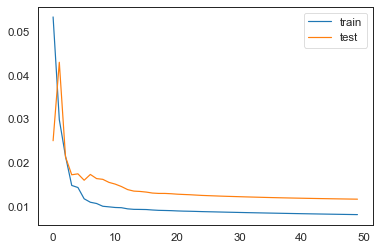

In [114]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluate Model

In [115]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat_concat = np.concatenate((test_X[:, :],yhat), axis=1)
print(yhat.shape)
print(test_X.shape)

inv_yhat = scaler.inverse_transform(inv_yhat_concat)
print(inv_yhat.shape)
inv_yhat_final = inv_yhat[:,-1].astype(int)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_concat = np.concatenate((test_X[:, :],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y_concat)
inv_y_final = inv_y[:,-1].astype(int)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(58, 1)
(58, 49)
(58, 50)
Test RMSE: 8.765


In [106]:
inv_y_final #Original Data

array([299, 252, 200, 187, 182,  27, 100, 270, 258, 283, 203, 119,  10,
        94, 281, 252, 194, 241, 174,  50,  97, 271, 264, 269, 284, 151,
        28, 114, 369, 299, 362, 285, 233,  13,  82, 357, 287, 264, 322,
       190,  12,  86, 324, 345, 282, 287, 184,  18,  75, 244,  80,  14,
        47, 126,  13,  68, 195, 157])

In [107]:
inv_yhat_final #Predicted Data

array([300, 266, 288, 261, 152,  15,  74, 278, 267, 268, 249, 162,  18,
        74, 279, 272, 278, 247, 157,  21,  85, 288, 273, 276, 259, 172,
        29,  87, 294, 295, 302, 271, 183,  38,  79, 281, 277, 289, 259,
       170,  26,  80, 285, 277, 289, 269, 172,  25,  82, 287, 276, 270,
       233, 135,   8,  82, 288, 257])